In [1]:
import numpy as np

actions = np.load('actions.npy')
states = np.load('observations.npy')
rewards = np.load('rewards.npy')
terminals = np.load('terminals.npy')



In [7]:
print(rewards.shape)

(64000,)


In [14]:
%load_ext autoreload
%autoreload 2
device = 'cuda:2'

In [16]:
import argparse
import copy
import os
import sys
import numpy as np
import gymnasium as gym
import gym
import d4rl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Categorical
from torch.nn import functional as F
from tqdm import tqdm
from stable_baselines3 import PPO, SAC
import torch

sys.path.append('/home/hossein/Off-Policy-Evaluation-Lab')



-1683.8746009976226
145.16597510373444


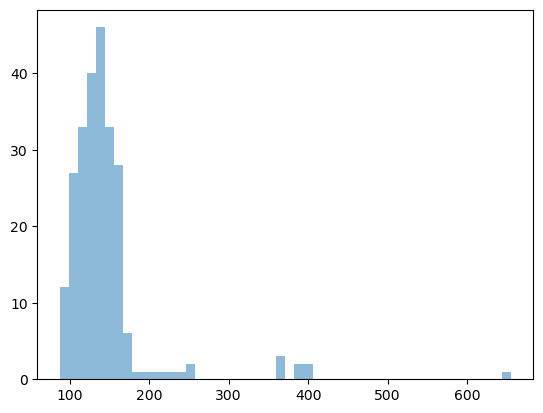

In [18]:
#read dataset/100k/rewards.npy and dataset/100k/terminals.npy
import numpy as np
import matplotlib.pyplot as plt

dataset_name = 'acrobat'

def load_generated_dataset(dataset_name):
    observations = np.load(f'observations.npy')
    actions = np.load(f'actions.npy')
    rewards = np.load(f'rewards.npy')
    terminals = np.load(f'terminals.npy')
    return observations, actions, rewards, terminals

observations, actions, rewards, terminals = load_generated_dataset(dataset_name)

#find average reward of trajs
reward_trajectories = []
length_trajectories = []

end_idxs = np.where(terminals)[0]
start_idxs = np.concatenate([[0], end_idxs[:-1] + 1])

for start, end in zip(start_idxs, end_idxs):
    reward_trajectories.append(rewards[start:end].sum())
    length_trajectories.append(end - start)

reward_trajectories = np.array(reward_trajectories)
length_trajectories = np.array(length_trajectories)

print(np.mean(reward_trajectories))
print(np.mean(length_trajectories))

dataset = {
    'observations': observations,
    'actions': actions,
    'rewards': rewards,
    'terminals': terminals   
}

plt.hist(length_trajectories, bins=50, alpha=0.5, label='length')
plt.show()

In [21]:
from torch.utils.data import DataLoader, Dataset
import sys
import os
import json

sys.path.append('/home/hossein/Off-Policy-Evaluation-Lab')

from opelab.core.baselines.diffusion.temporal import TemporalUnet
from opelab.core.baselines.diffusion.diffusion import GaussianDiffusion
from opelab.core.task import ContinuousAcrobotEnv

env = ContinuousAcrobotEnv()

state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.shape[0]

print(f'state_dim = {state_dim}')
print(f'action_dim = {action_dim}')


state_dim = 6
action_dim = 1


In [27]:
def get_mean_std(path):
    #in the dataset/{path}/normalization.json
    path = os.path.join('normalization.json')
    with open(path, 'r') as f:
        data = json.load(f)
        mean_s = torch.tensor(data['state_mean'], dtype=torch.float32)
        std_s = torch.tensor(data['state_std'], dtype=torch.float32)
        mean_a = torch.tensor(data['action_mean'], dtype=torch.float32)
        std_a = torch.tensor(data['action_std'], dtype=torch.float32)
        mean = torch.cat([mean_s, mean_a])
        std = torch.cat([std_s, std_a])
        return mean, std

mean, std = get_mean_std('acrobat')

def normalize(data, mean, std):
    return (data - mean) / std

def unnormalize(data, mean, std):
    return data * std + mean

normalize_fn = lambda data: normalize(data, mean.to(device), std.to(device))
unnormalize_fn = lambda data: unnormalize(data, mean.to(device), std.to(device))


In [25]:
T = 32
D = 128

temporal_model = TemporalUnet(
    horizon=T,
    transition_dim=state_dim + action_dim,
).to(device)

diffusion_model = GaussianDiffusion(
    model=temporal_model,
    horizon=T,
    observation_dim=state_dim,
    action_dim=action_dim,
    n_timesteps=D,
    normalizer=normalize_fn,
    unnormalizer=unnormalize_fn,
).to(device)

model_path = '/home/hossein/Off-Policy-Evaluation-Lab/opelab/examples/gym/cacrobat/T32D128/acrobat.pth'

diffusion_model.load_state_dict(torch.load(model_path))


[ models/temporal ] Channel dimensions: [(7, 32), (32, 64), (64, 128), (128, 256)]
[(7, 32), (32, 64), (64, 128), (128, 256)]


<All keys matched successfully>

In [31]:
def generate_and_print_trajectories(diffusion_model, T):
    num_samples = 1  # Adjust the number of samples as needed
    #generated_trajectories = diffusion_model.p_sample_loop((num_samples, T , state_dim + action_dim), scale=0)[0]
    state = torch.tensor(np.concatenate((env.reset(), np.zeros(action_dim))),device=device)
    state = normalize_fn(state)
    state = state[:state_dim]
    cond = {0:state}
    generated_trajectories = diffusion_model.conditional_sample((num_samples, 32 , state_dim + action_dim), cond)[0]
    unnormalized_trajectories = unnormalize_fn(generated_trajectories)

    # Print the first element of the first time step of each trajectory
    for i in range(31):
        print(f'Trajectory {i} element : {unnormalized_trajectories[0, i, 2]}')

generate_and_print_trajectories(diffusion_model, T)


                                                                                                    
1 / 128 [                                                            ]   0% | 38.1 Hz
t : 127
                                                                                                    
                                                                                                    
2 / 128 [                                                            ]   1% | 47.6 Hz
t : 126
                                                                                                    
                                                                                                    
3 / 128 [#                                                           ]   2% | 52.5 Hz
t : 125
                                                                                                    
                                                                                                    
4 / 128 [#

In [54]:
import numpy as np
import torch
from torch import cos

def is_terminated(state):
    s = state
    cos_theta1 = s[0]
    sin_theta1 = s[1]
    cos_theta2 = s[2]
    sin_theta2 = s[3]
    print(f'height= {-cos_theta1 - (cos_theta1 * cos_theta2 - sin_theta1 * sin_theta2)}')
    return bool(-cos_theta1 - (cos_theta1 * cos_theta2 - sin_theta1 * sin_theta2) > 1.0)

In [55]:
import torch

def generate_full_trajectory(diffusion_model, normalize_fn, unnormalize_fn, is_terminated_fn, initial_state, 
                             state_dim, action_dim, batch_size=10, trajectory_max_length=32, mini_trajectory_size=8, device='cuda'):
    
    initial_state_tensor = torch.tensor(initial_state, dtype=torch.float32, device=device)
    normalized_initial = normalize_fn(
        torch.cat([
            initial_state_tensor, 
            torch.zeros(action_dim, device=device)
        ])
    )[:state_dim]

    alive_indices = torch.arange(0, batch_size, dtype=torch.long, device=device) 
    conditions = {0: normalized_initial.unsqueeze(0).repeat(batch_size, 1)}  
    all_trajectories = torch.zeros((batch_size, trajectory_max_length, state_dim + action_dim), device=device)
    end_indices = torch.full((batch_size,), trajectory_max_length, dtype=torch.long, device=device) 

    total_generated = 0  

    while alive_indices.numel() > 0 and total_generated < trajectory_max_length:
        current_batch_size = alive_indices.size(0)
        shape = (current_batch_size, mini_trajectory_size, state_dim + action_dim)
        
        samples = diffusion_model.conditional_sample(shape, conditions, guided=False, action_scale=0.3, state_scale=0.01,
                                                     use_adaptive=True, use_neg_grad=True, neg_grad_scale=0.3,
                                                     normalize_grad=True, k_guide=2, use_action_grad_only=True)[0]
        samples = unnormalize_fn(samples)

        new_alive_indices = []
        new_local_alive_indices = []
        steps_added = min(trajectory_max_length - total_generated, mini_trajectory_size - 1)

        for local_idx, global_idx in enumerate(alive_indices):
            trajectory = samples[local_idx]
            for step_idx in range(mini_trajectory_size):
                if total_generated + step_idx >= trajectory_max_length:
                    end_indices[global_idx] = trajectory_max_length
                    all_trajectories[global_idx, total_generated:] = trajectory[:step_idx]
                    break  # Stop if the total trajectory length is exceeded
                if is_terminated_fn(trajectory[step_idx, :state_dim]):
                    end_indices[global_idx] = min(total_generated + step_idx, trajectory_max_length)
                    all_trajectories[global_idx, total_generated:total_generated + step_idx] = trajectory[:step_idx]
                    break
            else:
                steps_to_store = min(mini_trajectory_size - 1, trajectory_max_length - total_generated)
                all_trajectories[global_idx, total_generated:total_generated + steps_to_store] = trajectory[:steps_to_store]
                new_alive_indices.append(global_idx)
                new_local_alive_indices.append(local_idx)

        alive_indices = torch.tensor(new_alive_indices, device=device)  

        if alive_indices.numel() > 0:
            active_samples = samples[new_local_alive_indices]  
            last_states = active_samples[:, -1, :state_dim]    
            normalized_states = normalize_fn(torch.cat([
                last_states,
                torch.zeros((last_states.size(0), action_dim), device=device)
            ], dim=1))[:, :state_dim]
            conditions = {0: normalized_states}
        
        total_generated += steps_added
    
    print(f"Generated {total_generated} steps")

    return all_trajectories, end_indices

# Example usage
initial_state = dataset['observations'][0]
full_trajectory, end_indices = generate_full_trajectory(diffusion_model, normalize_fn, unnormalize_fn, is_terminated, 
                                                        initial_state, state_dim, action_dim, batch_size=10, 
                                                        trajectory_max_length=512, mini_trajectory_size=32, device=device)



                                                                                                    
1 / 128 [                                                            ]   0% | 91.0 Hz
t : 127
                                                                                                    
                                                                                                    
2 / 128 [                                                            ]   1% | 95.7 Hz
t : 126
                                                                                                    
                                                                                                    
3 / 128 [#                                                           ]   2% | 97.3 Hz
t : 125
                                                                                                    
                                                                                                    
4 / 128 [#

                                                                                                    
                                                                                                    
19 / 128 [########                                                    ]  14% | 85.3 Hz
t : 109
                                                                                                    
                                                                                                    
20 / 128 [#########                                                   ]  15% | 84.7 Hz
t : 108
                                                                                                    
                                                                                                    
21 / 128 [#########                                                   ]  16% | 84.7 Hz
t : 107
                                                                                                    
        

KeyboardInterrupt: 

In [51]:
print(end_indices)

tensor([512, 257, 120, 512, 468, 343, 512, 512, 289, 512], device='cuda:2')


In [47]:
full_trajectory[0,0:100,0]

tensor([ 0.9958,  0.9952,  0.9947,  0.9912,  0.9891,  0.9913,  0.9929,  0.9942,
         0.9859,  0.9802,  0.9799,  0.9913,  0.9934,  0.9793,  0.9612,  0.9545,
         0.9672,  0.9858,  0.9908,  0.9602,  0.9112,  0.8924,  0.9253,  0.9781,
         0.9897,  0.9312,  0.8469,  0.8116,  0.8625,  0.9581,  0.9896,  0.9034,
         0.7826,  0.7618,  0.8592,  0.9770,  0.9787,  0.8554,  0.7145,  0.6648,
         0.7477,  0.9180,  1.0033,  0.8765,  0.6665,  0.5504,  0.5922,  0.7707,
         0.9739,  0.9686,  0.7024,  0.4751,  0.4392,  0.6123,  0.8743,  0.9984,
         0.8245,  0.4721,  0.2677,  0.3250,  0.6083,  0.9261,  0.9741,  0.6763,
         0.2845,  0.1125,  0.2283,  0.5830,  0.9411,  0.9026,  0.4388,  0.0027,
        -0.1909, -0.1470,  0.1616,  0.6713,  1.0016,  0.7293,  0.2008, -0.1719,
        -0.2995, -0.1841,  0.1880,  0.7198,  0.9971,  0.6211,  0.0526, -0.3328,
        -0.4737, -0.4067, -0.1054,  0.4414,  0.9483,  0.8012,  0.2094, -0.2544,
        -0.4866, -0.5265, -0.4081, -0.05